### Subpixel rendering for diamond-shaped PenTile displays using deep convolutional networks

#### Import package

In [1]:
# PyTorch is an optimized tensor library for deep learning using GPUs and CPUs.
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import DataLoader

#The torchvision package consists of popular datasets, model architectures, and common image transformations for computer vision.
from torchvision.transforms import Compose, CenterCrop, ToTensor, Resize

import matplotlib
import matplotlib.pyplot as plt

from os import listdir
from os.path import join
from os.path import exists, join, basename
from os import makedirs, remove

from PIL import Image
from six.moves import urllib
import tarfile
from __future__ import print_function
import argparse
from math import log10

### Prepare the Data

In [2]:
def is_image_file(filename):
    return any(filename.endswith(extension) for extension in [".png", ".jpg", ".jpeg"]) #T/F 반환


def load_img(filepath):
    img = Image.open(filepath)
    return img #image 반환

creating a custom dataset

In [3]:
class DatasetFromFolder(data.Dataset):
    #The __init__ function is run once when instantiating the Dataset object
    def __init__(self, image_dir, input_transform=None, target_transform=None):
        super(DatasetFromFolder, self).__init__()
        self.image_filenames = [join(image_dir, x) for x in listdir(image_dir) if is_image_file(x)]

        self.input_transform = input_transform
        self.target_transform = target_transform
    
    #The __getitem__ function loads and returns a sample from the dataset at the given index idx
    def __getitem__(self, index):
        input = load_img(self.image_filenames[index])
        target = input.copy()
        if self.input_transform:
            input = self.input_transform(input)
        if self.target_transform:
            target = self.target_transform(target)

        return input, target

    #The __len__ function returns the number of samples in our dataset
    def __len__(self):
        return len(self.image_filenames)

#### Download Dataset

In [4]:
def download_bsd300(dest="dataset"):
    output_image_dir = join(dest, "BSDS300/images")

    if not exists(output_image_dir):
        makedirs(dest)
        url = "http://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300-images.tgz"
        print("downloading url ", url)

        data = urllib.request.urlopen(url)

        file_path = join(dest, basename(url))
        with open(file_path, 'wb') as f:
            f.write(data.read())

        print("Extracting data")
        with tarfile.open(file_path) as tar:
            for item in tar:
                tar.extract(item, dest)

        remove(file_path)

    return output_image_dir

#### Define the image transformation

In [5]:
def input_transform(crop_size, upscale_factor):
    return Compose([
        CenterCrop(crop_size),
        Resize(crop_size // upscale_factor),
        ToTensor(),
    ])

def target_transform(crop_size):
    return Compose([
        CenterCrop(crop_size),
        ToTensor(),
    ])

#### Load Dataset

In [6]:
def get_training_set(upscale_factor):
    root_dir = download_bsd300()
    train_dir = join(root_dir, "train")
    crop_size = 300

    return DatasetFromFolder(train_dir,
                             input_transform=input_transform(crop_size, upscale_factor),
                             target_transform=target_transform(crop_size))


def get_test_set(upscale_factor):
    root_dir = download_bsd300()
    test_dir = join(root_dir, "test")
    crop_size = 300

    return DatasetFromFolder(test_dir,
                             input_transform=input_transform(crop_size, upscale_factor),
                             target_transform=target_transform(crop_size))

### Define the Model

In [7]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 128, kernel_size=7, padding=2)
        self.conv2 = nn.Conv2d(128, 128, kernel_size=1, padding=2, stride=2)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=1, padding=0, stride=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=1, padding=0, stride=1)
        self.conv10 = nn.Conv2d(128, 128, kernel_size=1, padding=0, stride=1)
        self.conv5 = nn.Conv2d(128, 1, kernel_size=6, padding=2)
        self.conv6 = nn.Conv2d(128, 1, kernel_size=6, padding=2, stride=2, padding_mode='replicate')
        self.conv7 = nn.Conv2d(128, 1, kernel_size=6, padding=2, stride=2, padding_mode='replicate')
        self.conv8 = nn.Conv2d(128, 1, kernel_size=6, padding=2, stride=2, padding_mode='replicate')
        self.conv9 = nn.Conv2d(128, 1, kernel_size=6, padding=2, stride=2, padding_mode='replicate')
        
        #RGB to Diamond PenTile
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv10(x))
        
        g = self.conv5(x)
        r1 = self.conv6(x)
        r2 = self.conv7(x)
        b1 = self.conv8(x)
        b2 = self.conv9(x)
        
        #Diamond PenTile to RGB Virtual image
        mask_G = torch.tensor([
            [1, 0],
            [0, 0], 
        ])
        
        mask_R1 = torch.tensor([
            [0, 0, 0, 0],
            [0, 1, 0, 0],
            [0, 0, 0, 0],
            [0, 0, 0, 0],
        ])

        mask_R2 = torch.tensor([
            [0, 0, 0, 0],
            [0, 0, 0, 0],
            [0, 0, 0, 0],
            [0, 0, 0, 1],
        ])

        mask_B1 = torch.tensor([
            [0, 0, 0, 0],
            [0, 0, 0, 1],
            [0, 0, 0, 0],
            [0, 0, 0, 0],
        ])

        mask_B2 = torch.tensor([
            [0, 0, 0, 0],
            [0, 0, 0, 0],
            [0, 0, 0, 0],
            [0, 1, 0, 0],
        ])

        mask_G = mask_G.view(1,1,2,2).float()
        mask_R1 = mask_R1.view(1,1,4,4).float()
        mask_R2 = mask_R2.view(1,1,4,4).float()
        mask_B1 = mask_B1.view(1,1,4,4).float()
        mask_B2 = mask_B2.view(1,1,4,4).float()
        
        mask_G = mask_G.to(device)
        mask_R1 = mask_R1.to(device)
        mask_R2 = mask_R2.to(device)
        mask_B1 = mask_B1.to(device)
        mask_B2 = mask_B2.to(device)
        
        g = F.conv_transpose2d(g, mask_G, stride=2, padding=0)
        r1 = F.conv_transpose2d(r1, mask_R1, stride=4, padding=0)
        r2 = F.conv_transpose2d(r2, mask_R2, stride=4, padding=0)
        b1 = F.conv_transpose2d(b1, mask_B1, stride=4, padding=0)
        b2 = F.conv_transpose2d(b2, mask_B2, stride=4, padding=0)
        
        r, b = torch.add(r1,r2), torch.add(b1,b2)
       
        weights_G = torch.tensor([
            [0.25, 0.5, 0.25],
            [ 0.5,   1,  0.5],
            [0.25, 0.5, 0.25],   
        ])
        
        weights_RB = torch.tensor([
            [   0,    0,    0, 0.06,    0,    0,    0],
            [   0,    0, 0.19, 0.25, 0.19,    0,    0],
            [   0, 0.19,  0.5, 0.56,  0.5, 0.19,    0],
            [0.06, 0.25, 0.56,  1.0, 0.56, 0.25, 0.06],
            [   0, 0.19,  0.5, 0.56,  0.5, 0.19,    0],
            [   0,    0, 0.19, 0.25, 0.19,    0,    0],
            [   0,    0,    0, 0.06,    0,    0,    0],
        ])

        weights_G = weights_G.view(1,1,3,3).float()
        weights_RB = weights_RB.view(1,1,7,7).float()
        
        weights_G = weights_G.to(device)
        weights_RB = weights_RB.to(device)
        
        g = F.conv2d(g, weights_G, None, 1, 1)
        r = F.conv2d(r, weights_RB, None, 1, 3)
        b = F.conv2d(b, weights_RB, None, 1, 3)
        
        outputs = torch.cat((r,g,b), dim=1)
     
        return outputs

### Train the Model

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

prepare data for training with Dataloaders

In [9]:
print('===> Loading datasets')
train_set = get_training_set(upscale_factor=1)
test_set = get_test_set(upscale_factor=1)
training_data_loader = DataLoader(dataset=train_set, num_workers=0, batch_size=10, shuffle=True)
testing_data_loader = DataLoader(dataset=test_set, num_workers=0, batch_size=10, shuffle=False)

===> Loading datasets


In [10]:
print('===> Building model')
model = Net().to(device)

===> Building model


#### Initialize the Loss function and optimizer

In [11]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [12]:
train_loss, val_loss = [], []
train_psnr, val_psnr = [], []

#### Define Train loop and Test loop

In [13]:
def train(epoch):
    epoch_loss = 0
    for iteration, batch in enumerate(training_data_loader, 1):
        input, target = batch[0].to(device), batch[1].to(device)

        optimizer.zero_grad()
        loss = criterion(model(input), target)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()

        print("===> Epoch[{}]({}/{}): Loss: {:.4f}".format(epoch, iteration, len(training_data_loader), loss.item()))

    print("===> Epoch {} Complete: Avg. Loss: {:.4f}".format(epoch, epoch_loss / len(training_data_loader)))
    train_loss.append(epoch_loss / len(training_data_loader))


def test():
    avg_psnr = 0
    with torch.no_grad():
        for batch in testing_data_loader:
            input, target = batch[0].to(device), batch[1].to(device)

            prediction = model(input)
            mse = criterion(prediction, target)
            psnr = 10 * log10(1 / mse.item())
            avg_psnr += psnr
            
    print("===> Avg. PSNR: {:.4f} dB".format(avg_psnr / len(testing_data_loader)))
    val_psnr.append(avg_psnr / len(testing_data_loader))


def checkpoint(epoch):
    model_out_path = "model_epoch_{}.pth".format(epoch)
    torch.save(model, model_out_path)
    print("Checkpoint saved to {}".format(model_out_path))

We initialize the loss function and optimizer, and pass it to train loop and test loop

In [14]:
for epoch in range(1, 500 + 1):
    train(epoch)
    test()
    checkpoint(epoch)

===> Epoch[1](1/20): Loss: 0.2676
===> Epoch[1](2/20): Loss: 0.2121
===> Epoch[1](3/20): Loss: 0.2326
===> Epoch[1](4/20): Loss: 0.1690
===> Epoch[1](5/20): Loss: 0.2002
===> Epoch[1](6/20): Loss: 0.2388
===> Epoch[1](7/20): Loss: 0.1664
===> Epoch[1](8/20): Loss: 0.1391
===> Epoch[1](9/20): Loss: 0.1537
===> Epoch[1](10/20): Loss: 0.1574
===> Epoch[1](11/20): Loss: 0.1201
===> Epoch[1](12/20): Loss: 0.1394
===> Epoch[1](13/20): Loss: 0.1021
===> Epoch[1](14/20): Loss: 0.1104
===> Epoch[1](15/20): Loss: 0.1007
===> Epoch[1](16/20): Loss: 0.0973
===> Epoch[1](17/20): Loss: 0.0799
===> Epoch[1](18/20): Loss: 0.0746
===> Epoch[1](19/20): Loss: 0.0808
===> Epoch[1](20/20): Loss: 0.0561
===> Epoch 1 Complete: Avg. Loss: 0.1449
===> Avg. PSNR: 12.1191 dB
Checkpoint saved to model_epoch_1.pth
===> Epoch[2](1/20): Loss: 0.0677
===> Epoch[2](2/20): Loss: 0.0637
===> Epoch[2](3/20): Loss: 0.0630
===> Epoch[2](4/20): Loss: 0.0435
===> Epoch[2](5/20): Loss: 0.0413
===> Epoch[2](6/20): Loss: 0.0429

===> Epoch[11](7/20): Loss: 0.0081
===> Epoch[11](8/20): Loss: 0.0112
===> Epoch[11](9/20): Loss: 0.0101
===> Epoch[11](10/20): Loss: 0.0115
===> Epoch[11](11/20): Loss: 0.0114
===> Epoch[11](12/20): Loss: 0.0079
===> Epoch[11](13/20): Loss: 0.0120
===> Epoch[11](14/20): Loss: 0.0086
===> Epoch[11](15/20): Loss: 0.0121
===> Epoch[11](16/20): Loss: 0.0101
===> Epoch[11](17/20): Loss: 0.0090
===> Epoch[11](18/20): Loss: 0.0116
===> Epoch[11](19/20): Loss: 0.0094
===> Epoch[11](20/20): Loss: 0.0111
===> Epoch 11 Complete: Avg. Loss: 0.0104
===> Avg. PSNR: 20.0159 dB
Checkpoint saved to model_epoch_11.pth
===> Epoch[12](1/20): Loss: 0.0085
===> Epoch[12](2/20): Loss: 0.0118
===> Epoch[12](3/20): Loss: 0.0096
===> Epoch[12](4/20): Loss: 0.0078
===> Epoch[12](5/20): Loss: 0.0099
===> Epoch[12](6/20): Loss: 0.0110
===> Epoch[12](7/20): Loss: 0.0115
===> Epoch[12](8/20): Loss: 0.0063
===> Epoch[12](9/20): Loss: 0.0080
===> Epoch[12](10/20): Loss: 0.0087
===> Epoch[12](11/20): Loss: 0.0104
===>

===> Epoch[21](8/20): Loss: 0.0047
===> Epoch[21](9/20): Loss: 0.0064
===> Epoch[21](10/20): Loss: 0.0034
===> Epoch[21](11/20): Loss: 0.0055
===> Epoch[21](12/20): Loss: 0.0066
===> Epoch[21](13/20): Loss: 0.0041
===> Epoch[21](14/20): Loss: 0.0050
===> Epoch[21](15/20): Loss: 0.0047
===> Epoch[21](16/20): Loss: 0.0047
===> Epoch[21](17/20): Loss: 0.0043
===> Epoch[21](18/20): Loss: 0.0048
===> Epoch[21](19/20): Loss: 0.0055
===> Epoch[21](20/20): Loss: 0.0040
===> Epoch 21 Complete: Avg. Loss: 0.0051
===> Avg. PSNR: 22.8291 dB
Checkpoint saved to model_epoch_21.pth
===> Epoch[22](1/20): Loss: 0.0045
===> Epoch[22](2/20): Loss: 0.0040
===> Epoch[22](3/20): Loss: 0.0047
===> Epoch[22](4/20): Loss: 0.0056
===> Epoch[22](5/20): Loss: 0.0049
===> Epoch[22](6/20): Loss: 0.0069
===> Epoch[22](7/20): Loss: 0.0040
===> Epoch[22](8/20): Loss: 0.0049
===> Epoch[22](9/20): Loss: 0.0050
===> Epoch[22](10/20): Loss: 0.0046
===> Epoch[22](11/20): Loss: 0.0047
===> Epoch[22](12/20): Loss: 0.0038
===

===> Epoch[31](9/20): Loss: 0.0026
===> Epoch[31](10/20): Loss: 0.0040
===> Epoch[31](11/20): Loss: 0.0030
===> Epoch[31](12/20): Loss: 0.0046
===> Epoch[31](13/20): Loss: 0.0040
===> Epoch[31](14/20): Loss: 0.0044
===> Epoch[31](15/20): Loss: 0.0050
===> Epoch[31](16/20): Loss: 0.0040
===> Epoch[31](17/20): Loss: 0.0037
===> Epoch[31](18/20): Loss: 0.0030
===> Epoch[31](19/20): Loss: 0.0039
===> Epoch[31](20/20): Loss: 0.0044
===> Epoch 31 Complete: Avg. Loss: 0.0039
===> Avg. PSNR: 23.7715 dB
Checkpoint saved to model_epoch_31.pth
===> Epoch[32](1/20): Loss: 0.0043
===> Epoch[32](2/20): Loss: 0.0043
===> Epoch[32](3/20): Loss: 0.0041
===> Epoch[32](4/20): Loss: 0.0061
===> Epoch[32](5/20): Loss: 0.0037
===> Epoch[32](6/20): Loss: 0.0027
===> Epoch[32](7/20): Loss: 0.0045
===> Epoch[32](8/20): Loss: 0.0036
===> Epoch[32](9/20): Loss: 0.0034
===> Epoch[32](10/20): Loss: 0.0036
===> Epoch[32](11/20): Loss: 0.0031
===> Epoch[32](12/20): Loss: 0.0039
===> Epoch[32](13/20): Loss: 0.0042
==

===> Epoch[41](10/20): Loss: 0.0037
===> Epoch[41](11/20): Loss: 0.0029
===> Epoch[41](12/20): Loss: 0.0042
===> Epoch[41](13/20): Loss: 0.0043
===> Epoch[41](14/20): Loss: 0.0046
===> Epoch[41](15/20): Loss: 0.0030
===> Epoch[41](16/20): Loss: 0.0034
===> Epoch[41](17/20): Loss: 0.0032
===> Epoch[41](18/20): Loss: 0.0037
===> Epoch[41](19/20): Loss: 0.0035
===> Epoch[41](20/20): Loss: 0.0034
===> Epoch 41 Complete: Avg. Loss: 0.0036
===> Avg. PSNR: 24.1539 dB
Checkpoint saved to model_epoch_41.pth
===> Epoch[42](1/20): Loss: 0.0042
===> Epoch[42](2/20): Loss: 0.0042
===> Epoch[42](3/20): Loss: 0.0042
===> Epoch[42](4/20): Loss: 0.0044
===> Epoch[42](5/20): Loss: 0.0036
===> Epoch[42](6/20): Loss: 0.0033
===> Epoch[42](7/20): Loss: 0.0034
===> Epoch[42](8/20): Loss: 0.0037
===> Epoch[42](9/20): Loss: 0.0042
===> Epoch[42](10/20): Loss: 0.0046
===> Epoch[42](11/20): Loss: 0.0039
===> Epoch[42](12/20): Loss: 0.0031
===> Epoch[42](13/20): Loss: 0.0040
===> Epoch[42](14/20): Loss: 0.0037
=

===> Epoch[51](11/20): Loss: 0.0039
===> Epoch[51](12/20): Loss: 0.0043
===> Epoch[51](13/20): Loss: 0.0040
===> Epoch[51](14/20): Loss: 0.0046
===> Epoch[51](15/20): Loss: 0.0039
===> Epoch[51](16/20): Loss: 0.0026
===> Epoch[51](17/20): Loss: 0.0026
===> Epoch[51](18/20): Loss: 0.0029
===> Epoch[51](19/20): Loss: 0.0040
===> Epoch[51](20/20): Loss: 0.0039
===> Epoch 51 Complete: Avg. Loss: 0.0035
===> Avg. PSNR: 24.1493 dB
Checkpoint saved to model_epoch_51.pth
===> Epoch[52](1/20): Loss: 0.0034
===> Epoch[52](2/20): Loss: 0.0026
===> Epoch[52](3/20): Loss: 0.0033
===> Epoch[52](4/20): Loss: 0.0035
===> Epoch[52](5/20): Loss: 0.0046
===> Epoch[52](6/20): Loss: 0.0037
===> Epoch[52](7/20): Loss: 0.0037
===> Epoch[52](8/20): Loss: 0.0035
===> Epoch[52](9/20): Loss: 0.0036
===> Epoch[52](10/20): Loss: 0.0047
===> Epoch[52](11/20): Loss: 0.0031
===> Epoch[52](12/20): Loss: 0.0041
===> Epoch[52](13/20): Loss: 0.0051
===> Epoch[52](14/20): Loss: 0.0039
===> Epoch[52](15/20): Loss: 0.0036
=

===> Epoch[61](12/20): Loss: 0.0040
===> Epoch[61](13/20): Loss: 0.0044
===> Epoch[61](14/20): Loss: 0.0041
===> Epoch[61](15/20): Loss: 0.0040
===> Epoch[61](16/20): Loss: 0.0028
===> Epoch[61](17/20): Loss: 0.0029
===> Epoch[61](18/20): Loss: 0.0034
===> Epoch[61](19/20): Loss: 0.0028
===> Epoch[61](20/20): Loss: 0.0029
===> Epoch 61 Complete: Avg. Loss: 0.0034
===> Avg. PSNR: 24.4359 dB
Checkpoint saved to model_epoch_61.pth
===> Epoch[62](1/20): Loss: 0.0032
===> Epoch[62](2/20): Loss: 0.0039
===> Epoch[62](3/20): Loss: 0.0035
===> Epoch[62](4/20): Loss: 0.0032
===> Epoch[62](5/20): Loss: 0.0042
===> Epoch[62](6/20): Loss: 0.0043
===> Epoch[62](7/20): Loss: 0.0034
===> Epoch[62](8/20): Loss: 0.0033
===> Epoch[62](9/20): Loss: 0.0036
===> Epoch[62](10/20): Loss: 0.0026
===> Epoch[62](11/20): Loss: 0.0039
===> Epoch[62](12/20): Loss: 0.0036
===> Epoch[62](13/20): Loss: 0.0043
===> Epoch[62](14/20): Loss: 0.0028
===> Epoch[62](15/20): Loss: 0.0030
===> Epoch[62](16/20): Loss: 0.0025
=

===> Epoch[71](13/20): Loss: 0.0033
===> Epoch[71](14/20): Loss: 0.0032
===> Epoch[71](15/20): Loss: 0.0038
===> Epoch[71](16/20): Loss: 0.0030
===> Epoch[71](17/20): Loss: 0.0037
===> Epoch[71](18/20): Loss: 0.0034
===> Epoch[71](19/20): Loss: 0.0047
===> Epoch[71](20/20): Loss: 0.0048
===> Epoch 71 Complete: Avg. Loss: 0.0033
===> Avg. PSNR: 24.4912 dB
Checkpoint saved to model_epoch_71.pth
===> Epoch[72](1/20): Loss: 0.0025
===> Epoch[72](2/20): Loss: 0.0020
===> Epoch[72](3/20): Loss: 0.0029
===> Epoch[72](4/20): Loss: 0.0033
===> Epoch[72](5/20): Loss: 0.0036
===> Epoch[72](6/20): Loss: 0.0026
===> Epoch[72](7/20): Loss: 0.0032
===> Epoch[72](8/20): Loss: 0.0036
===> Epoch[72](9/20): Loss: 0.0044
===> Epoch[72](10/20): Loss: 0.0038
===> Epoch[72](11/20): Loss: 0.0025
===> Epoch[72](12/20): Loss: 0.0040
===> Epoch[72](13/20): Loss: 0.0026
===> Epoch[72](14/20): Loss: 0.0024
===> Epoch[72](15/20): Loss: 0.0033
===> Epoch[72](16/20): Loss: 0.0050
===> Epoch[72](17/20): Loss: 0.0024
=

===> Epoch[81](14/20): Loss: 0.0045
===> Epoch[81](15/20): Loss: 0.0023
===> Epoch[81](16/20): Loss: 0.0029
===> Epoch[81](17/20): Loss: 0.0047
===> Epoch[81](18/20): Loss: 0.0025
===> Epoch[81](19/20): Loss: 0.0028
===> Epoch[81](20/20): Loss: 0.0040
===> Epoch 81 Complete: Avg. Loss: 0.0034
===> Avg. PSNR: 24.5327 dB
Checkpoint saved to model_epoch_81.pth
===> Epoch[82](1/20): Loss: 0.0041
===> Epoch[82](2/20): Loss: 0.0031
===> Epoch[82](3/20): Loss: 0.0036
===> Epoch[82](4/20): Loss: 0.0034
===> Epoch[82](5/20): Loss: 0.0042
===> Epoch[82](6/20): Loss: 0.0051
===> Epoch[82](7/20): Loss: 0.0026
===> Epoch[82](8/20): Loss: 0.0036
===> Epoch[82](9/20): Loss: 0.0024
===> Epoch[82](10/20): Loss: 0.0036
===> Epoch[82](11/20): Loss: 0.0023
===> Epoch[82](12/20): Loss: 0.0028
===> Epoch[82](13/20): Loss: 0.0030
===> Epoch[82](14/20): Loss: 0.0028
===> Epoch[82](15/20): Loss: 0.0031
===> Epoch[82](16/20): Loss: 0.0029
===> Epoch[82](17/20): Loss: 0.0039
===> Epoch[82](18/20): Loss: 0.0038
=

===> Epoch[91](15/20): Loss: 0.0029
===> Epoch[91](16/20): Loss: 0.0035
===> Epoch[91](17/20): Loss: 0.0030
===> Epoch[91](18/20): Loss: 0.0038
===> Epoch[91](19/20): Loss: 0.0035
===> Epoch[91](20/20): Loss: 0.0033
===> Epoch 91 Complete: Avg. Loss: 0.0033
===> Avg. PSNR: 24.5839 dB
Checkpoint saved to model_epoch_91.pth
===> Epoch[92](1/20): Loss: 0.0031
===> Epoch[92](2/20): Loss: 0.0027
===> Epoch[92](3/20): Loss: 0.0030
===> Epoch[92](4/20): Loss: 0.0033
===> Epoch[92](5/20): Loss: 0.0031
===> Epoch[92](6/20): Loss: 0.0037
===> Epoch[92](7/20): Loss: 0.0035
===> Epoch[92](8/20): Loss: 0.0039
===> Epoch[92](9/20): Loss: 0.0024
===> Epoch[92](10/20): Loss: 0.0029
===> Epoch[92](11/20): Loss: 0.0027
===> Epoch[92](12/20): Loss: 0.0043
===> Epoch[92](13/20): Loss: 0.0028
===> Epoch[92](14/20): Loss: 0.0028
===> Epoch[92](15/20): Loss: 0.0047
===> Epoch[92](16/20): Loss: 0.0031
===> Epoch[92](17/20): Loss: 0.0038
===> Epoch[92](18/20): Loss: 0.0022
===> Epoch[92](19/20): Loss: 0.0038
=

===> Epoch[101](15/20): Loss: 0.0020
===> Epoch[101](16/20): Loss: 0.0034
===> Epoch[101](17/20): Loss: 0.0020
===> Epoch[101](18/20): Loss: 0.0034
===> Epoch[101](19/20): Loss: 0.0031
===> Epoch[101](20/20): Loss: 0.0038
===> Epoch 101 Complete: Avg. Loss: 0.0033
===> Avg. PSNR: 24.5929 dB
Checkpoint saved to model_epoch_101.pth
===> Epoch[102](1/20): Loss: 0.0037
===> Epoch[102](2/20): Loss: 0.0046
===> Epoch[102](3/20): Loss: 0.0032
===> Epoch[102](4/20): Loss: 0.0034
===> Epoch[102](5/20): Loss: 0.0023
===> Epoch[102](6/20): Loss: 0.0047
===> Epoch[102](7/20): Loss: 0.0036
===> Epoch[102](8/20): Loss: 0.0042
===> Epoch[102](9/20): Loss: 0.0031
===> Epoch[102](10/20): Loss: 0.0024
===> Epoch[102](11/20): Loss: 0.0029
===> Epoch[102](12/20): Loss: 0.0040
===> Epoch[102](13/20): Loss: 0.0036
===> Epoch[102](14/20): Loss: 0.0033
===> Epoch[102](15/20): Loss: 0.0026
===> Epoch[102](16/20): Loss: 0.0021
===> Epoch[102](17/20): Loss: 0.0029
===> Epoch[102](18/20): Loss: 0.0033
===> Epoch[

===> Epoch[111](10/20): Loss: 0.0029
===> Epoch[111](11/20): Loss: 0.0025
===> Epoch[111](12/20): Loss: 0.0029
===> Epoch[111](13/20): Loss: 0.0035
===> Epoch[111](14/20): Loss: 0.0036
===> Epoch[111](15/20): Loss: 0.0025
===> Epoch[111](16/20): Loss: 0.0043
===> Epoch[111](17/20): Loss: 0.0030
===> Epoch[111](18/20): Loss: 0.0024
===> Epoch[111](19/20): Loss: 0.0030
===> Epoch[111](20/20): Loss: 0.0028
===> Epoch 111 Complete: Avg. Loss: 0.0032
===> Avg. PSNR: 24.6514 dB
Checkpoint saved to model_epoch_111.pth
===> Epoch[112](1/20): Loss: 0.0036
===> Epoch[112](2/20): Loss: 0.0037
===> Epoch[112](3/20): Loss: 0.0020
===> Epoch[112](4/20): Loss: 0.0033
===> Epoch[112](5/20): Loss: 0.0031
===> Epoch[112](6/20): Loss: 0.0027
===> Epoch[112](7/20): Loss: 0.0033
===> Epoch[112](8/20): Loss: 0.0026
===> Epoch[112](9/20): Loss: 0.0031
===> Epoch[112](10/20): Loss: 0.0033
===> Epoch[112](11/20): Loss: 0.0035
===> Epoch[112](12/20): Loss: 0.0027
===> Epoch[112](13/20): Loss: 0.0030
===> Epoch[

===> Epoch[121](4/20): Loss: 0.0033
===> Epoch[121](5/20): Loss: 0.0029
===> Epoch[121](6/20): Loss: 0.0027
===> Epoch[121](7/20): Loss: 0.0033
===> Epoch[121](8/20): Loss: 0.0033
===> Epoch[121](9/20): Loss: 0.0029
===> Epoch[121](10/20): Loss: 0.0025
===> Epoch[121](11/20): Loss: 0.0038
===> Epoch[121](12/20): Loss: 0.0038
===> Epoch[121](13/20): Loss: 0.0020
===> Epoch[121](14/20): Loss: 0.0031
===> Epoch[121](15/20): Loss: 0.0042
===> Epoch[121](16/20): Loss: 0.0034
===> Epoch[121](17/20): Loss: 0.0024
===> Epoch[121](18/20): Loss: 0.0032
===> Epoch[121](19/20): Loss: 0.0040
===> Epoch[121](20/20): Loss: 0.0026
===> Epoch 121 Complete: Avg. Loss: 0.0032
===> Avg. PSNR: 24.6916 dB
Checkpoint saved to model_epoch_121.pth
===> Epoch[122](1/20): Loss: 0.0035
===> Epoch[122](2/20): Loss: 0.0024
===> Epoch[122](3/20): Loss: 0.0034
===> Epoch[122](4/20): Loss: 0.0040
===> Epoch[122](5/20): Loss: 0.0039
===> Epoch[122](6/20): Loss: 0.0024
===> Epoch[122](7/20): Loss: 0.0043
===> Epoch[122]

===> Avg. PSNR: 24.7173 dB
Checkpoint saved to model_epoch_130.pth
===> Epoch[131](1/20): Loss: 0.0022
===> Epoch[131](2/20): Loss: 0.0037
===> Epoch[131](3/20): Loss: 0.0040
===> Epoch[131](4/20): Loss: 0.0029
===> Epoch[131](5/20): Loss: 0.0024
===> Epoch[131](6/20): Loss: 0.0047
===> Epoch[131](7/20): Loss: 0.0033
===> Epoch[131](8/20): Loss: 0.0035
===> Epoch[131](9/20): Loss: 0.0020
===> Epoch[131](10/20): Loss: 0.0032
===> Epoch[131](11/20): Loss: 0.0029
===> Epoch[131](12/20): Loss: 0.0027
===> Epoch[131](13/20): Loss: 0.0035
===> Epoch[131](14/20): Loss: 0.0038
===> Epoch[131](15/20): Loss: 0.0029
===> Epoch[131](16/20): Loss: 0.0031
===> Epoch[131](17/20): Loss: 0.0033
===> Epoch[131](18/20): Loss: 0.0027
===> Epoch[131](19/20): Loss: 0.0035
===> Epoch[131](20/20): Loss: 0.0028
===> Epoch 131 Complete: Avg. Loss: 0.0031
===> Avg. PSNR: 24.7228 dB
Checkpoint saved to model_epoch_131.pth
===> Epoch[132](1/20): Loss: 0.0043
===> Epoch[132](2/20): Loss: 0.0027
===> Epoch[132](3/20

===> Epoch[140](17/20): Loss: 0.0057
===> Epoch[140](18/20): Loss: 0.0037
===> Epoch[140](19/20): Loss: 0.0027
===> Epoch[140](20/20): Loss: 0.0024
===> Epoch 140 Complete: Avg. Loss: 0.0036
===> Avg. PSNR: 24.1047 dB
Checkpoint saved to model_epoch_140.pth
===> Epoch[141](1/20): Loss: 0.0041
===> Epoch[141](2/20): Loss: 0.0032
===> Epoch[141](3/20): Loss: 0.0037
===> Epoch[141](4/20): Loss: 0.0033
===> Epoch[141](5/20): Loss: 0.0035
===> Epoch[141](6/20): Loss: 0.0034
===> Epoch[141](7/20): Loss: 0.0033
===> Epoch[141](8/20): Loss: 0.0039
===> Epoch[141](9/20): Loss: 0.0029
===> Epoch[141](10/20): Loss: 0.0039
===> Epoch[141](11/20): Loss: 0.0027
===> Epoch[141](12/20): Loss: 0.0021
===> Epoch[141](13/20): Loss: 0.0026
===> Epoch[141](14/20): Loss: 0.0031
===> Epoch[141](15/20): Loss: 0.0053
===> Epoch[141](16/20): Loss: 0.0032
===> Epoch[141](17/20): Loss: 0.0026
===> Epoch[141](18/20): Loss: 0.0033
===> Epoch[141](19/20): Loss: 0.0027
===> Epoch[141](20/20): Loss: 0.0039
===> Epoch 

===> Epoch[150](12/20): Loss: 0.0027
===> Epoch[150](13/20): Loss: 0.0037
===> Epoch[150](14/20): Loss: 0.0033
===> Epoch[150](15/20): Loss: 0.0030
===> Epoch[150](16/20): Loss: 0.0033
===> Epoch[150](17/20): Loss: 0.0034
===> Epoch[150](18/20): Loss: 0.0026
===> Epoch[150](19/20): Loss: 0.0023
===> Epoch[150](20/20): Loss: 0.0030
===> Epoch 150 Complete: Avg. Loss: 0.0031
===> Avg. PSNR: 24.7736 dB
Checkpoint saved to model_epoch_150.pth
===> Epoch[151](1/20): Loss: 0.0033
===> Epoch[151](2/20): Loss: 0.0033
===> Epoch[151](3/20): Loss: 0.0036
===> Epoch[151](4/20): Loss: 0.0029
===> Epoch[151](5/20): Loss: 0.0035
===> Epoch[151](6/20): Loss: 0.0039
===> Epoch[151](7/20): Loss: 0.0031
===> Epoch[151](8/20): Loss: 0.0028
===> Epoch[151](9/20): Loss: 0.0026
===> Epoch[151](10/20): Loss: 0.0026
===> Epoch[151](11/20): Loss: 0.0027
===> Epoch[151](12/20): Loss: 0.0032
===> Epoch[151](13/20): Loss: 0.0027
===> Epoch[151](14/20): Loss: 0.0030
===> Epoch[151](15/20): Loss: 0.0028
===> Epoch[

===> Epoch[160](7/20): Loss: 0.0027
===> Epoch[160](8/20): Loss: 0.0033
===> Epoch[160](9/20): Loss: 0.0040
===> Epoch[160](10/20): Loss: 0.0031
===> Epoch[160](11/20): Loss: 0.0024
===> Epoch[160](12/20): Loss: 0.0019
===> Epoch[160](13/20): Loss: 0.0029
===> Epoch[160](14/20): Loss: 0.0024
===> Epoch[160](15/20): Loss: 0.0033
===> Epoch[160](16/20): Loss: 0.0036
===> Epoch[160](17/20): Loss: 0.0032
===> Epoch[160](18/20): Loss: 0.0030
===> Epoch[160](19/20): Loss: 0.0025
===> Epoch[160](20/20): Loss: 0.0032
===> Epoch 160 Complete: Avg. Loss: 0.0031
===> Avg. PSNR: 24.7999 dB
Checkpoint saved to model_epoch_160.pth
===> Epoch[161](1/20): Loss: 0.0044
===> Epoch[161](2/20): Loss: 0.0030
===> Epoch[161](3/20): Loss: 0.0025
===> Epoch[161](4/20): Loss: 0.0021
===> Epoch[161](5/20): Loss: 0.0022
===> Epoch[161](6/20): Loss: 0.0023
===> Epoch[161](7/20): Loss: 0.0046
===> Epoch[161](8/20): Loss: 0.0029
===> Epoch[161](9/20): Loss: 0.0028
===> Epoch[161](10/20): Loss: 0.0023
===> Epoch[161

===> Epoch[170](1/20): Loss: 0.0031
===> Epoch[170](2/20): Loss: 0.0044
===> Epoch[170](3/20): Loss: 0.0027
===> Epoch[170](4/20): Loss: 0.0027
===> Epoch[170](5/20): Loss: 0.0018
===> Epoch[170](6/20): Loss: 0.0022
===> Epoch[170](7/20): Loss: 0.0027
===> Epoch[170](8/20): Loss: 0.0033
===> Epoch[170](9/20): Loss: 0.0027
===> Epoch[170](10/20): Loss: 0.0043
===> Epoch[170](11/20): Loss: 0.0037
===> Epoch[170](12/20): Loss: 0.0024
===> Epoch[170](13/20): Loss: 0.0022
===> Epoch[170](14/20): Loss: 0.0026
===> Epoch[170](15/20): Loss: 0.0038
===> Epoch[170](16/20): Loss: 0.0033
===> Epoch[170](17/20): Loss: 0.0037
===> Epoch[170](18/20): Loss: 0.0039
===> Epoch[170](19/20): Loss: 0.0030
===> Epoch[170](20/20): Loss: 0.0029
===> Epoch 170 Complete: Avg. Loss: 0.0031
===> Avg. PSNR: 24.8278 dB
Checkpoint saved to model_epoch_170.pth
===> Epoch[171](1/20): Loss: 0.0025
===> Epoch[171](2/20): Loss: 0.0033
===> Epoch[171](3/20): Loss: 0.0026
===> Epoch[171](4/20): Loss: 0.0027
===> Epoch[171]

===> Epoch[179](19/20): Loss: 0.0023
===> Epoch[179](20/20): Loss: 0.0029
===> Epoch 179 Complete: Avg. Loss: 0.0032
===> Avg. PSNR: 24.8279 dB
Checkpoint saved to model_epoch_179.pth
===> Epoch[180](1/20): Loss: 0.0029
===> Epoch[180](2/20): Loss: 0.0024
===> Epoch[180](3/20): Loss: 0.0035
===> Epoch[180](4/20): Loss: 0.0033
===> Epoch[180](5/20): Loss: 0.0024
===> Epoch[180](6/20): Loss: 0.0033
===> Epoch[180](7/20): Loss: 0.0040
===> Epoch[180](8/20): Loss: 0.0027
===> Epoch[180](9/20): Loss: 0.0033
===> Epoch[180](10/20): Loss: 0.0027
===> Epoch[180](11/20): Loss: 0.0029
===> Epoch[180](12/20): Loss: 0.0025
===> Epoch[180](13/20): Loss: 0.0029
===> Epoch[180](14/20): Loss: 0.0020
===> Epoch[180](15/20): Loss: 0.0037
===> Epoch[180](16/20): Loss: 0.0037
===> Epoch[180](17/20): Loss: 0.0036
===> Epoch[180](18/20): Loss: 0.0034
===> Epoch[180](19/20): Loss: 0.0032
===> Epoch[180](20/20): Loss: 0.0030
===> Epoch 180 Complete: Avg. Loss: 0.0031
===> Avg. PSNR: 24.8454 dB
Checkpoint save

===> Epoch[189](14/20): Loss: 0.0040
===> Epoch[189](15/20): Loss: 0.0032
===> Epoch[189](16/20): Loss: 0.0029
===> Epoch[189](17/20): Loss: 0.0024
===> Epoch[189](18/20): Loss: 0.0030
===> Epoch[189](19/20): Loss: 0.0039
===> Epoch[189](20/20): Loss: 0.0031
===> Epoch 189 Complete: Avg. Loss: 0.0030
===> Avg. PSNR: 24.8586 dB
Checkpoint saved to model_epoch_189.pth
===> Epoch[190](1/20): Loss: 0.0034
===> Epoch[190](2/20): Loss: 0.0034
===> Epoch[190](3/20): Loss: 0.0024
===> Epoch[190](4/20): Loss: 0.0030
===> Epoch[190](5/20): Loss: 0.0038
===> Epoch[190](6/20): Loss: 0.0018
===> Epoch[190](7/20): Loss: 0.0033
===> Epoch[190](8/20): Loss: 0.0033
===> Epoch[190](9/20): Loss: 0.0032
===> Epoch[190](10/20): Loss: 0.0028
===> Epoch[190](11/20): Loss: 0.0042
===> Epoch[190](12/20): Loss: 0.0033
===> Epoch[190](13/20): Loss: 0.0023
===> Epoch[190](14/20): Loss: 0.0035
===> Epoch[190](15/20): Loss: 0.0037
===> Epoch[190](16/20): Loss: 0.0026
===> Epoch[190](17/20): Loss: 0.0026
===> Epoch[

===> Epoch[199](9/20): Loss: 0.0024
===> Epoch[199](10/20): Loss: 0.0023
===> Epoch[199](11/20): Loss: 0.0032
===> Epoch[199](12/20): Loss: 0.0031
===> Epoch[199](13/20): Loss: 0.0030
===> Epoch[199](14/20): Loss: 0.0042
===> Epoch[199](15/20): Loss: 0.0031
===> Epoch[199](16/20): Loss: 0.0030
===> Epoch[199](17/20): Loss: 0.0022
===> Epoch[199](18/20): Loss: 0.0025
===> Epoch[199](19/20): Loss: 0.0029
===> Epoch[199](20/20): Loss: 0.0021
===> Epoch 199 Complete: Avg. Loss: 0.0030
===> Avg. PSNR: 24.8886 dB
Checkpoint saved to model_epoch_199.pth
===> Epoch[200](1/20): Loss: 0.0028
===> Epoch[200](2/20): Loss: 0.0025
===> Epoch[200](3/20): Loss: 0.0031
===> Epoch[200](4/20): Loss: 0.0031
===> Epoch[200](5/20): Loss: 0.0032
===> Epoch[200](6/20): Loss: 0.0023
===> Epoch[200](7/20): Loss: 0.0027
===> Epoch[200](8/20): Loss: 0.0021
===> Epoch[200](9/20): Loss: 0.0034
===> Epoch[200](10/20): Loss: 0.0033
===> Epoch[200](11/20): Loss: 0.0037
===> Epoch[200](12/20): Loss: 0.0035
===> Epoch[2

===> Epoch[209](3/20): Loss: 0.0031
===> Epoch[209](4/20): Loss: 0.0029
===> Epoch[209](5/20): Loss: 0.0030
===> Epoch[209](6/20): Loss: 0.0039
===> Epoch[209](7/20): Loss: 0.0039
===> Epoch[209](8/20): Loss: 0.0032
===> Epoch[209](9/20): Loss: 0.0025
===> Epoch[209](10/20): Loss: 0.0029
===> Epoch[209](11/20): Loss: 0.0032
===> Epoch[209](12/20): Loss: 0.0023
===> Epoch[209](13/20): Loss: 0.0022
===> Epoch[209](14/20): Loss: 0.0019
===> Epoch[209](15/20): Loss: 0.0031
===> Epoch[209](16/20): Loss: 0.0029
===> Epoch[209](17/20): Loss: 0.0028
===> Epoch[209](18/20): Loss: 0.0037
===> Epoch[209](19/20): Loss: 0.0030
===> Epoch[209](20/20): Loss: 0.0026
===> Epoch 209 Complete: Avg. Loss: 0.0030
===> Avg. PSNR: 24.9105 dB
Checkpoint saved to model_epoch_209.pth
===> Epoch[210](1/20): Loss: 0.0023
===> Epoch[210](2/20): Loss: 0.0028
===> Epoch[210](3/20): Loss: 0.0033
===> Epoch[210](4/20): Loss: 0.0041
===> Epoch[210](5/20): Loss: 0.0021
===> Epoch[210](6/20): Loss: 0.0029
===> Epoch[210]

===> Avg. PSNR: 24.9349 dB
Checkpoint saved to model_epoch_218.pth
===> Epoch[219](1/20): Loss: 0.0032
===> Epoch[219](2/20): Loss: 0.0033
===> Epoch[219](3/20): Loss: 0.0029
===> Epoch[219](4/20): Loss: 0.0030
===> Epoch[219](5/20): Loss: 0.0021
===> Epoch[219](6/20): Loss: 0.0038
===> Epoch[219](7/20): Loss: 0.0021
===> Epoch[219](8/20): Loss: 0.0026
===> Epoch[219](9/20): Loss: 0.0030
===> Epoch[219](10/20): Loss: 0.0039
===> Epoch[219](11/20): Loss: 0.0029
===> Epoch[219](12/20): Loss: 0.0040
===> Epoch[219](13/20): Loss: 0.0029
===> Epoch[219](14/20): Loss: 0.0026
===> Epoch[219](15/20): Loss: 0.0020
===> Epoch[219](16/20): Loss: 0.0035
===> Epoch[219](17/20): Loss: 0.0040
===> Epoch[219](18/20): Loss: 0.0027
===> Epoch[219](19/20): Loss: 0.0023
===> Epoch[219](20/20): Loss: 0.0029
===> Epoch 219 Complete: Avg. Loss: 0.0030
===> Avg. PSNR: 24.9356 dB
Checkpoint saved to model_epoch_219.pth
===> Epoch[220](1/20): Loss: 0.0032
===> Epoch[220](2/20): Loss: 0.0021
===> Epoch[220](3/20

===> Epoch[228](17/20): Loss: 0.0033
===> Epoch[228](18/20): Loss: 0.0024
===> Epoch[228](19/20): Loss: 0.0031
===> Epoch[228](20/20): Loss: 0.0038
===> Epoch 228 Complete: Avg. Loss: 0.0030
===> Avg. PSNR: 24.9447 dB
Checkpoint saved to model_epoch_228.pth
===> Epoch[229](1/20): Loss: 0.0034
===> Epoch[229](2/20): Loss: 0.0037
===> Epoch[229](3/20): Loss: 0.0030
===> Epoch[229](4/20): Loss: 0.0022
===> Epoch[229](5/20): Loss: 0.0026
===> Epoch[229](6/20): Loss: 0.0024
===> Epoch[229](7/20): Loss: 0.0037
===> Epoch[229](8/20): Loss: 0.0021
===> Epoch[229](9/20): Loss: 0.0029
===> Epoch[229](10/20): Loss: 0.0026
===> Epoch[229](11/20): Loss: 0.0043
===> Epoch[229](12/20): Loss: 0.0036
===> Epoch[229](13/20): Loss: 0.0027
===> Epoch[229](14/20): Loss: 0.0030
===> Epoch[229](15/20): Loss: 0.0020
===> Epoch[229](16/20): Loss: 0.0025
===> Epoch[229](17/20): Loss: 0.0022
===> Epoch[229](18/20): Loss: 0.0035
===> Epoch[229](19/20): Loss: 0.0045
===> Epoch[229](20/20): Loss: 0.0027
===> Epoch 

===> Epoch[238](12/20): Loss: 0.0028
===> Epoch[238](13/20): Loss: 0.0038
===> Epoch[238](14/20): Loss: 0.0035
===> Epoch[238](15/20): Loss: 0.0030
===> Epoch[238](16/20): Loss: 0.0032
===> Epoch[238](17/20): Loss: 0.0030
===> Epoch[238](18/20): Loss: 0.0030
===> Epoch[238](19/20): Loss: 0.0020
===> Epoch[238](20/20): Loss: 0.0035
===> Epoch 238 Complete: Avg. Loss: 0.0030
===> Avg. PSNR: 24.9530 dB
Checkpoint saved to model_epoch_238.pth
===> Epoch[239](1/20): Loss: 0.0023
===> Epoch[239](2/20): Loss: 0.0023
===> Epoch[239](3/20): Loss: 0.0034
===> Epoch[239](4/20): Loss: 0.0029
===> Epoch[239](5/20): Loss: 0.0035
===> Epoch[239](6/20): Loss: 0.0030
===> Epoch[239](7/20): Loss: 0.0036
===> Epoch[239](8/20): Loss: 0.0031
===> Epoch[239](9/20): Loss: 0.0036
===> Epoch[239](10/20): Loss: 0.0031
===> Epoch[239](11/20): Loss: 0.0028
===> Epoch[239](12/20): Loss: 0.0027
===> Epoch[239](13/20): Loss: 0.0029
===> Epoch[239](14/20): Loss: 0.0035
===> Epoch[239](15/20): Loss: 0.0027
===> Epoch[

===> Epoch[248](7/20): Loss: 0.0029
===> Epoch[248](8/20): Loss: 0.0024
===> Epoch[248](9/20): Loss: 0.0024
===> Epoch[248](10/20): Loss: 0.0027
===> Epoch[248](11/20): Loss: 0.0028
===> Epoch[248](12/20): Loss: 0.0029
===> Epoch[248](13/20): Loss: 0.0025
===> Epoch[248](14/20): Loss: 0.0033
===> Epoch[248](15/20): Loss: 0.0027
===> Epoch[248](16/20): Loss: 0.0025
===> Epoch[248](17/20): Loss: 0.0026
===> Epoch[248](18/20): Loss: 0.0033
===> Epoch[248](19/20): Loss: 0.0029
===> Epoch[248](20/20): Loss: 0.0033
===> Epoch 248 Complete: Avg. Loss: 0.0030
===> Avg. PSNR: 24.9434 dB
Checkpoint saved to model_epoch_248.pth
===> Epoch[249](1/20): Loss: 0.0017
===> Epoch[249](2/20): Loss: 0.0036
===> Epoch[249](3/20): Loss: 0.0026
===> Epoch[249](4/20): Loss: 0.0028
===> Epoch[249](5/20): Loss: 0.0030
===> Epoch[249](6/20): Loss: 0.0036
===> Epoch[249](7/20): Loss: 0.0026
===> Epoch[249](8/20): Loss: 0.0031
===> Epoch[249](9/20): Loss: 0.0022
===> Epoch[249](10/20): Loss: 0.0033
===> Epoch[249

===> Epoch[258](1/20): Loss: 0.0031
===> Epoch[258](2/20): Loss: 0.0037
===> Epoch[258](3/20): Loss: 0.0037
===> Epoch[258](4/20): Loss: 0.0028
===> Epoch[258](5/20): Loss: 0.0022
===> Epoch[258](6/20): Loss: 0.0028
===> Epoch[258](7/20): Loss: 0.0024
===> Epoch[258](8/20): Loss: 0.0029
===> Epoch[258](9/20): Loss: 0.0025
===> Epoch[258](10/20): Loss: 0.0033
===> Epoch[258](11/20): Loss: 0.0039
===> Epoch[258](12/20): Loss: 0.0027
===> Epoch[258](13/20): Loss: 0.0033
===> Epoch[258](14/20): Loss: 0.0038
===> Epoch[258](15/20): Loss: 0.0028
===> Epoch[258](16/20): Loss: 0.0021
===> Epoch[258](17/20): Loss: 0.0031
===> Epoch[258](18/20): Loss: 0.0018
===> Epoch[258](19/20): Loss: 0.0036
===> Epoch[258](20/20): Loss: 0.0026
===> Epoch 258 Complete: Avg. Loss: 0.0030
===> Avg. PSNR: 24.9781 dB
Checkpoint saved to model_epoch_258.pth
===> Epoch[259](1/20): Loss: 0.0036
===> Epoch[259](2/20): Loss: 0.0023
===> Epoch[259](3/20): Loss: 0.0026
===> Epoch[259](4/20): Loss: 0.0031
===> Epoch[259]

===> Epoch[267](19/20): Loss: 0.0023
===> Epoch[267](20/20): Loss: 0.0021
===> Epoch 267 Complete: Avg. Loss: 0.0029
===> Avg. PSNR: 24.9612 dB
Checkpoint saved to model_epoch_267.pth
===> Epoch[268](1/20): Loss: 0.0027
===> Epoch[268](2/20): Loss: 0.0043
===> Epoch[268](3/20): Loss: 0.0031
===> Epoch[268](4/20): Loss: 0.0034
===> Epoch[268](5/20): Loss: 0.0027
===> Epoch[268](6/20): Loss: 0.0021
===> Epoch[268](7/20): Loss: 0.0023
===> Epoch[268](8/20): Loss: 0.0027
===> Epoch[268](9/20): Loss: 0.0043
===> Epoch[268](10/20): Loss: 0.0032
===> Epoch[268](11/20): Loss: 0.0030
===> Epoch[268](12/20): Loss: 0.0024
===> Epoch[268](13/20): Loss: 0.0031
===> Epoch[268](14/20): Loss: 0.0035
===> Epoch[268](15/20): Loss: 0.0026
===> Epoch[268](16/20): Loss: 0.0030
===> Epoch[268](17/20): Loss: 0.0023
===> Epoch[268](18/20): Loss: 0.0020
===> Epoch[268](19/20): Loss: 0.0038
===> Epoch[268](20/20): Loss: 0.0027
===> Epoch 268 Complete: Avg. Loss: 0.0030
===> Avg. PSNR: 24.9640 dB
Checkpoint save

===> Epoch[277](14/20): Loss: 0.0029
===> Epoch[277](15/20): Loss: 0.0029
===> Epoch[277](16/20): Loss: 0.0030
===> Epoch[277](17/20): Loss: 0.0022
===> Epoch[277](18/20): Loss: 0.0030
===> Epoch[277](19/20): Loss: 0.0031
===> Epoch[277](20/20): Loss: 0.0026
===> Epoch 277 Complete: Avg. Loss: 0.0030
===> Avg. PSNR: 24.9904 dB
Checkpoint saved to model_epoch_277.pth
===> Epoch[278](1/20): Loss: 0.0026
===> Epoch[278](2/20): Loss: 0.0033
===> Epoch[278](3/20): Loss: 0.0020
===> Epoch[278](4/20): Loss: 0.0024
===> Epoch[278](5/20): Loss: 0.0024
===> Epoch[278](6/20): Loss: 0.0017
===> Epoch[278](7/20): Loss: 0.0037
===> Epoch[278](8/20): Loss: 0.0033
===> Epoch[278](9/20): Loss: 0.0030
===> Epoch[278](10/20): Loss: 0.0031
===> Epoch[278](11/20): Loss: 0.0025
===> Epoch[278](12/20): Loss: 0.0030
===> Epoch[278](13/20): Loss: 0.0052
===> Epoch[278](14/20): Loss: 0.0029
===> Epoch[278](15/20): Loss: 0.0028
===> Epoch[278](16/20): Loss: 0.0023
===> Epoch[278](17/20): Loss: 0.0035
===> Epoch[

===> Epoch[287](9/20): Loss: 0.0027
===> Epoch[287](10/20): Loss: 0.0021
===> Epoch[287](11/20): Loss: 0.0034
===> Epoch[287](12/20): Loss: 0.0031
===> Epoch[287](13/20): Loss: 0.0027
===> Epoch[287](14/20): Loss: 0.0027
===> Epoch[287](15/20): Loss: 0.0035
===> Epoch[287](16/20): Loss: 0.0033
===> Epoch[287](17/20): Loss: 0.0035
===> Epoch[287](18/20): Loss: 0.0028
===> Epoch[287](19/20): Loss: 0.0026
===> Epoch[287](20/20): Loss: 0.0044
===> Epoch 287 Complete: Avg. Loss: 0.0029
===> Avg. PSNR: 25.0025 dB
Checkpoint saved to model_epoch_287.pth
===> Epoch[288](1/20): Loss: 0.0025
===> Epoch[288](2/20): Loss: 0.0039
===> Epoch[288](3/20): Loss: 0.0024
===> Epoch[288](4/20): Loss: 0.0024
===> Epoch[288](5/20): Loss: 0.0024
===> Epoch[288](6/20): Loss: 0.0024
===> Epoch[288](7/20): Loss: 0.0032
===> Epoch[288](8/20): Loss: 0.0033
===> Epoch[288](9/20): Loss: 0.0036
===> Epoch[288](10/20): Loss: 0.0033
===> Epoch[288](11/20): Loss: 0.0017
===> Epoch[288](12/20): Loss: 0.0037
===> Epoch[2

===> Epoch[297](3/20): Loss: 0.0030
===> Epoch[297](4/20): Loss: 0.0029
===> Epoch[297](5/20): Loss: 0.0032
===> Epoch[297](6/20): Loss: 0.0031
===> Epoch[297](7/20): Loss: 0.0033
===> Epoch[297](8/20): Loss: 0.0021
===> Epoch[297](9/20): Loss: 0.0023
===> Epoch[297](10/20): Loss: 0.0040
===> Epoch[297](11/20): Loss: 0.0029
===> Epoch[297](12/20): Loss: 0.0030
===> Epoch[297](13/20): Loss: 0.0035
===> Epoch[297](14/20): Loss: 0.0028
===> Epoch[297](15/20): Loss: 0.0037
===> Epoch[297](16/20): Loss: 0.0024
===> Epoch[297](17/20): Loss: 0.0037
===> Epoch[297](18/20): Loss: 0.0028
===> Epoch[297](19/20): Loss: 0.0024
===> Epoch[297](20/20): Loss: 0.0022
===> Epoch 297 Complete: Avg. Loss: 0.0029
===> Avg. PSNR: 25.0087 dB
Checkpoint saved to model_epoch_297.pth
===> Epoch[298](1/20): Loss: 0.0029
===> Epoch[298](2/20): Loss: 0.0036
===> Epoch[298](3/20): Loss: 0.0032
===> Epoch[298](4/20): Loss: 0.0034
===> Epoch[298](5/20): Loss: 0.0024
===> Epoch[298](6/20): Loss: 0.0028
===> Epoch[298]

===> Avg. PSNR: 24.6921 dB
Checkpoint saved to model_epoch_306.pth
===> Epoch[307](1/20): Loss: 0.0040
===> Epoch[307](2/20): Loss: 0.0036
===> Epoch[307](3/20): Loss: 0.0040
===> Epoch[307](4/20): Loss: 0.0024
===> Epoch[307](5/20): Loss: 0.0033
===> Epoch[307](6/20): Loss: 0.0038
===> Epoch[307](7/20): Loss: 0.0037
===> Epoch[307](8/20): Loss: 0.0028
===> Epoch[307](9/20): Loss: 0.0019
===> Epoch[307](10/20): Loss: 0.0030
===> Epoch[307](11/20): Loss: 0.0024
===> Epoch[307](12/20): Loss: 0.0032
===> Epoch[307](13/20): Loss: 0.0025
===> Epoch[307](14/20): Loss: 0.0024
===> Epoch[307](15/20): Loss: 0.0025
===> Epoch[307](16/20): Loss: 0.0039
===> Epoch[307](17/20): Loss: 0.0031
===> Epoch[307](18/20): Loss: 0.0040
===> Epoch[307](19/20): Loss: 0.0017
===> Epoch[307](20/20): Loss: 0.0022
===> Epoch 307 Complete: Avg. Loss: 0.0030
===> Avg. PSNR: 24.9846 dB
Checkpoint saved to model_epoch_307.pth
===> Epoch[308](1/20): Loss: 0.0026
===> Epoch[308](2/20): Loss: 0.0021
===> Epoch[308](3/20

===> Epoch[316](17/20): Loss: 0.0037
===> Epoch[316](18/20): Loss: 0.0032
===> Epoch[316](19/20): Loss: 0.0027
===> Epoch[316](20/20): Loss: 0.0030
===> Epoch 316 Complete: Avg. Loss: 0.0029
===> Avg. PSNR: 25.0200 dB
Checkpoint saved to model_epoch_316.pth
===> Epoch[317](1/20): Loss: 0.0023
===> Epoch[317](2/20): Loss: 0.0034
===> Epoch[317](3/20): Loss: 0.0025
===> Epoch[317](4/20): Loss: 0.0026
===> Epoch[317](5/20): Loss: 0.0035
===> Epoch[317](6/20): Loss: 0.0034
===> Epoch[317](7/20): Loss: 0.0040
===> Epoch[317](8/20): Loss: 0.0032
===> Epoch[317](9/20): Loss: 0.0025
===> Epoch[317](10/20): Loss: 0.0033
===> Epoch[317](11/20): Loss: 0.0034
===> Epoch[317](12/20): Loss: 0.0025
===> Epoch[317](13/20): Loss: 0.0023
===> Epoch[317](14/20): Loss: 0.0027
===> Epoch[317](15/20): Loss: 0.0025
===> Epoch[317](16/20): Loss: 0.0029
===> Epoch[317](17/20): Loss: 0.0028
===> Epoch[317](18/20): Loss: 0.0030
===> Epoch[317](19/20): Loss: 0.0034
===> Epoch[317](20/20): Loss: 0.0021
===> Epoch 

===> Epoch[326](12/20): Loss: 0.0039
===> Epoch[326](13/20): Loss: 0.0023
===> Epoch[326](14/20): Loss: 0.0036
===> Epoch[326](15/20): Loss: 0.0037
===> Epoch[326](16/20): Loss: 0.0022
===> Epoch[326](17/20): Loss: 0.0032
===> Epoch[326](18/20): Loss: 0.0022
===> Epoch[326](19/20): Loss: 0.0039
===> Epoch[326](20/20): Loss: 0.0021
===> Epoch 326 Complete: Avg. Loss: 0.0029
===> Avg. PSNR: 25.0277 dB
Checkpoint saved to model_epoch_326.pth
===> Epoch[327](1/20): Loss: 0.0026
===> Epoch[327](2/20): Loss: 0.0029
===> Epoch[327](3/20): Loss: 0.0031
===> Epoch[327](4/20): Loss: 0.0025
===> Epoch[327](5/20): Loss: 0.0031
===> Epoch[327](6/20): Loss: 0.0020
===> Epoch[327](7/20): Loss: 0.0026
===> Epoch[327](8/20): Loss: 0.0051
===> Epoch[327](9/20): Loss: 0.0037
===> Epoch[327](10/20): Loss: 0.0036
===> Epoch[327](11/20): Loss: 0.0032
===> Epoch[327](12/20): Loss: 0.0037
===> Epoch[327](13/20): Loss: 0.0024
===> Epoch[327](14/20): Loss: 0.0026
===> Epoch[327](15/20): Loss: 0.0026
===> Epoch[

===> Epoch[336](7/20): Loss: 0.0024
===> Epoch[336](8/20): Loss: 0.0027
===> Epoch[336](9/20): Loss: 0.0033
===> Epoch[336](10/20): Loss: 0.0019
===> Epoch[336](11/20): Loss: 0.0041
===> Epoch[336](12/20): Loss: 0.0021
===> Epoch[336](13/20): Loss: 0.0032
===> Epoch[336](14/20): Loss: 0.0032
===> Epoch[336](15/20): Loss: 0.0031
===> Epoch[336](16/20): Loss: 0.0030
===> Epoch[336](17/20): Loss: 0.0029
===> Epoch[336](18/20): Loss: 0.0029
===> Epoch[336](19/20): Loss: 0.0023
===> Epoch[336](20/20): Loss: 0.0032
===> Epoch 336 Complete: Avg. Loss: 0.0029
===> Avg. PSNR: 25.0282 dB
Checkpoint saved to model_epoch_336.pth
===> Epoch[337](1/20): Loss: 0.0035
===> Epoch[337](2/20): Loss: 0.0034
===> Epoch[337](3/20): Loss: 0.0033
===> Epoch[337](4/20): Loss: 0.0029
===> Epoch[337](5/20): Loss: 0.0042
===> Epoch[337](6/20): Loss: 0.0030
===> Epoch[337](7/20): Loss: 0.0030
===> Epoch[337](8/20): Loss: 0.0027
===> Epoch[337](9/20): Loss: 0.0025
===> Epoch[337](10/20): Loss: 0.0023
===> Epoch[337

===> Epoch[346](1/20): Loss: 0.0035
===> Epoch[346](2/20): Loss: 0.0034
===> Epoch[346](3/20): Loss: 0.0024
===> Epoch[346](4/20): Loss: 0.0030
===> Epoch[346](5/20): Loss: 0.0039
===> Epoch[346](6/20): Loss: 0.0033
===> Epoch[346](7/20): Loss: 0.0022
===> Epoch[346](8/20): Loss: 0.0025
===> Epoch[346](9/20): Loss: 0.0021
===> Epoch[346](10/20): Loss: 0.0029
===> Epoch[346](11/20): Loss: 0.0029
===> Epoch[346](12/20): Loss: 0.0022
===> Epoch[346](13/20): Loss: 0.0034
===> Epoch[346](14/20): Loss: 0.0042
===> Epoch[346](15/20): Loss: 0.0020
===> Epoch[346](16/20): Loss: 0.0025
===> Epoch[346](17/20): Loss: 0.0031
===> Epoch[346](18/20): Loss: 0.0028
===> Epoch[346](19/20): Loss: 0.0032
===> Epoch[346](20/20): Loss: 0.0028
===> Epoch 346 Complete: Avg. Loss: 0.0029
===> Avg. PSNR: 25.0380 dB
Checkpoint saved to model_epoch_346.pth
===> Epoch[347](1/20): Loss: 0.0022
===> Epoch[347](2/20): Loss: 0.0017
===> Epoch[347](3/20): Loss: 0.0024
===> Epoch[347](4/20): Loss: 0.0027
===> Epoch[347]

===> Epoch[355](19/20): Loss: 0.0022
===> Epoch[355](20/20): Loss: 0.0032
===> Epoch 355 Complete: Avg. Loss: 0.0030
===> Avg. PSNR: 25.0350 dB
Checkpoint saved to model_epoch_355.pth
===> Epoch[356](1/20): Loss: 0.0041
===> Epoch[356](2/20): Loss: 0.0026
===> Epoch[356](3/20): Loss: 0.0031
===> Epoch[356](4/20): Loss: 0.0033
===> Epoch[356](5/20): Loss: 0.0028
===> Epoch[356](6/20): Loss: 0.0028
===> Epoch[356](7/20): Loss: 0.0024
===> Epoch[356](8/20): Loss: 0.0023
===> Epoch[356](9/20): Loss: 0.0035
===> Epoch[356](10/20): Loss: 0.0028
===> Epoch[356](11/20): Loss: 0.0034
===> Epoch[356](12/20): Loss: 0.0026
===> Epoch[356](13/20): Loss: 0.0028
===> Epoch[356](14/20): Loss: 0.0034
===> Epoch[356](15/20): Loss: 0.0021
===> Epoch[356](16/20): Loss: 0.0037
===> Epoch[356](17/20): Loss: 0.0025
===> Epoch[356](18/20): Loss: 0.0024
===> Epoch[356](19/20): Loss: 0.0028
===> Epoch[356](20/20): Loss: 0.0029
===> Epoch 356 Complete: Avg. Loss: 0.0029
===> Avg. PSNR: 25.0407 dB
Checkpoint save

===> Epoch[365](14/20): Loss: 0.0026
===> Epoch[365](15/20): Loss: 0.0024
===> Epoch[365](16/20): Loss: 0.0031
===> Epoch[365](17/20): Loss: 0.0037
===> Epoch[365](18/20): Loss: 0.0025
===> Epoch[365](19/20): Loss: 0.0035
===> Epoch[365](20/20): Loss: 0.0026
===> Epoch 365 Complete: Avg. Loss: 0.0029
===> Avg. PSNR: 25.0479 dB
Checkpoint saved to model_epoch_365.pth
===> Epoch[366](1/20): Loss: 0.0030
===> Epoch[366](2/20): Loss: 0.0038
===> Epoch[366](3/20): Loss: 0.0026
===> Epoch[366](4/20): Loss: 0.0024
===> Epoch[366](5/20): Loss: 0.0033
===> Epoch[366](6/20): Loss: 0.0034
===> Epoch[366](7/20): Loss: 0.0021
===> Epoch[366](8/20): Loss: 0.0033
===> Epoch[366](9/20): Loss: 0.0022
===> Epoch[366](10/20): Loss: 0.0028
===> Epoch[366](11/20): Loss: 0.0027
===> Epoch[366](12/20): Loss: 0.0043
===> Epoch[366](13/20): Loss: 0.0022
===> Epoch[366](14/20): Loss: 0.0021
===> Epoch[366](15/20): Loss: 0.0029
===> Epoch[366](16/20): Loss: 0.0032
===> Epoch[366](17/20): Loss: 0.0022
===> Epoch[

===> Epoch[375](9/20): Loss: 0.0041
===> Epoch[375](10/20): Loss: 0.0025
===> Epoch[375](11/20): Loss: 0.0038
===> Epoch[375](12/20): Loss: 0.0020
===> Epoch[375](13/20): Loss: 0.0037
===> Epoch[375](14/20): Loss: 0.0030
===> Epoch[375](15/20): Loss: 0.0031
===> Epoch[375](16/20): Loss: 0.0031
===> Epoch[375](17/20): Loss: 0.0025
===> Epoch[375](18/20): Loss: 0.0036
===> Epoch[375](19/20): Loss: 0.0024
===> Epoch[375](20/20): Loss: 0.0021
===> Epoch 375 Complete: Avg. Loss: 0.0029
===> Avg. PSNR: 25.0521 dB
Checkpoint saved to model_epoch_375.pth
===> Epoch[376](1/20): Loss: 0.0027
===> Epoch[376](2/20): Loss: 0.0023
===> Epoch[376](3/20): Loss: 0.0021
===> Epoch[376](4/20): Loss: 0.0032
===> Epoch[376](5/20): Loss: 0.0035
===> Epoch[376](6/20): Loss: 0.0029
===> Epoch[376](7/20): Loss: 0.0027
===> Epoch[376](8/20): Loss: 0.0034
===> Epoch[376](9/20): Loss: 0.0033
===> Epoch[376](10/20): Loss: 0.0040
===> Epoch[376](11/20): Loss: 0.0028
===> Epoch[376](12/20): Loss: 0.0031
===> Epoch[3

===> Epoch[385](3/20): Loss: 0.0027
===> Epoch[385](4/20): Loss: 0.0034
===> Epoch[385](5/20): Loss: 0.0026
===> Epoch[385](6/20): Loss: 0.0037
===> Epoch[385](7/20): Loss: 0.0019
===> Epoch[385](8/20): Loss: 0.0033
===> Epoch[385](9/20): Loss: 0.0023
===> Epoch[385](10/20): Loss: 0.0027
===> Epoch[385](11/20): Loss: 0.0024
===> Epoch[385](12/20): Loss: 0.0035
===> Epoch[385](13/20): Loss: 0.0027
===> Epoch[385](14/20): Loss: 0.0033
===> Epoch[385](15/20): Loss: 0.0025
===> Epoch[385](16/20): Loss: 0.0035
===> Epoch[385](17/20): Loss: 0.0022
===> Epoch[385](18/20): Loss: 0.0031
===> Epoch[385](19/20): Loss: 0.0027
===> Epoch[385](20/20): Loss: 0.0033
===> Epoch 385 Complete: Avg. Loss: 0.0029
===> Avg. PSNR: 25.0437 dB
Checkpoint saved to model_epoch_385.pth
===> Epoch[386](1/20): Loss: 0.0042
===> Epoch[386](2/20): Loss: 0.0026
===> Epoch[386](3/20): Loss: 0.0028
===> Epoch[386](4/20): Loss: 0.0031
===> Epoch[386](5/20): Loss: 0.0031
===> Epoch[386](6/20): Loss: 0.0027
===> Epoch[386]

===> Avg. PSNR: 25.0440 dB
Checkpoint saved to model_epoch_394.pth
===> Epoch[395](1/20): Loss: 0.0027
===> Epoch[395](2/20): Loss: 0.0031
===> Epoch[395](3/20): Loss: 0.0022
===> Epoch[395](4/20): Loss: 0.0033
===> Epoch[395](5/20): Loss: 0.0028
===> Epoch[395](6/20): Loss: 0.0030
===> Epoch[395](7/20): Loss: 0.0027
===> Epoch[395](8/20): Loss: 0.0042
===> Epoch[395](9/20): Loss: 0.0028
===> Epoch[395](10/20): Loss: 0.0015
===> Epoch[395](11/20): Loss: 0.0039
===> Epoch[395](12/20): Loss: 0.0029
===> Epoch[395](13/20): Loss: 0.0031
===> Epoch[395](14/20): Loss: 0.0033
===> Epoch[395](15/20): Loss: 0.0033
===> Epoch[395](16/20): Loss: 0.0018
===> Epoch[395](17/20): Loss: 0.0026
===> Epoch[395](18/20): Loss: 0.0035
===> Epoch[395](19/20): Loss: 0.0021
===> Epoch[395](20/20): Loss: 0.0031
===> Epoch 395 Complete: Avg. Loss: 0.0029
===> Avg. PSNR: 25.0604 dB
Checkpoint saved to model_epoch_395.pth
===> Epoch[396](1/20): Loss: 0.0022
===> Epoch[396](2/20): Loss: 0.0027
===> Epoch[396](3/20

===> Epoch[404](17/20): Loss: 0.0030
===> Epoch[404](18/20): Loss: 0.0018
===> Epoch[404](19/20): Loss: 0.0027
===> Epoch[404](20/20): Loss: 0.0025
===> Epoch 404 Complete: Avg. Loss: 0.0031
===> Avg. PSNR: 24.5610 dB
Checkpoint saved to model_epoch_404.pth
===> Epoch[405](1/20): Loss: 0.0027
===> Epoch[405](2/20): Loss: 0.0019
===> Epoch[405](3/20): Loss: 0.0031
===> Epoch[405](4/20): Loss: 0.0027
===> Epoch[405](5/20): Loss: 0.0029
===> Epoch[405](6/20): Loss: 0.0037
===> Epoch[405](7/20): Loss: 0.0023
===> Epoch[405](8/20): Loss: 0.0027
===> Epoch[405](9/20): Loss: 0.0032
===> Epoch[405](10/20): Loss: 0.0034
===> Epoch[405](11/20): Loss: 0.0023
===> Epoch[405](12/20): Loss: 0.0032
===> Epoch[405](13/20): Loss: 0.0039
===> Epoch[405](14/20): Loss: 0.0040
===> Epoch[405](15/20): Loss: 0.0036
===> Epoch[405](16/20): Loss: 0.0025
===> Epoch[405](17/20): Loss: 0.0038
===> Epoch[405](18/20): Loss: 0.0038
===> Epoch[405](19/20): Loss: 0.0028
===> Epoch[405](20/20): Loss: 0.0024
===> Epoch 

===> Epoch[414](12/20): Loss: 0.0026
===> Epoch[414](13/20): Loss: 0.0033
===> Epoch[414](14/20): Loss: 0.0030
===> Epoch[414](15/20): Loss: 0.0030
===> Epoch[414](16/20): Loss: 0.0034
===> Epoch[414](17/20): Loss: 0.0032
===> Epoch[414](18/20): Loss: 0.0031
===> Epoch[414](19/20): Loss: 0.0030
===> Epoch[414](20/20): Loss: 0.0023
===> Epoch 414 Complete: Avg. Loss: 0.0029
===> Avg. PSNR: 25.0666 dB
Checkpoint saved to model_epoch_414.pth
===> Epoch[415](1/20): Loss: 0.0054
===> Epoch[415](2/20): Loss: 0.0022
===> Epoch[415](3/20): Loss: 0.0022
===> Epoch[415](4/20): Loss: 0.0020
===> Epoch[415](5/20): Loss: 0.0022
===> Epoch[415](6/20): Loss: 0.0037
===> Epoch[415](7/20): Loss: 0.0024
===> Epoch[415](8/20): Loss: 0.0031
===> Epoch[415](9/20): Loss: 0.0025
===> Epoch[415](10/20): Loss: 0.0021
===> Epoch[415](11/20): Loss: 0.0035
===> Epoch[415](12/20): Loss: 0.0024
===> Epoch[415](13/20): Loss: 0.0041
===> Epoch[415](14/20): Loss: 0.0023
===> Epoch[415](15/20): Loss: 0.0029
===> Epoch[

===> Epoch[424](7/20): Loss: 0.0029
===> Epoch[424](8/20): Loss: 0.0038
===> Epoch[424](9/20): Loss: 0.0026
===> Epoch[424](10/20): Loss: 0.0023
===> Epoch[424](11/20): Loss: 0.0035
===> Epoch[424](12/20): Loss: 0.0024
===> Epoch[424](13/20): Loss: 0.0027
===> Epoch[424](14/20): Loss: 0.0042
===> Epoch[424](15/20): Loss: 0.0035
===> Epoch[424](16/20): Loss: 0.0034
===> Epoch[424](17/20): Loss: 0.0026
===> Epoch[424](18/20): Loss: 0.0029
===> Epoch[424](19/20): Loss: 0.0032
===> Epoch[424](20/20): Loss: 0.0026
===> Epoch 424 Complete: Avg. Loss: 0.0029
===> Avg. PSNR: 25.0724 dB
Checkpoint saved to model_epoch_424.pth
===> Epoch[425](1/20): Loss: 0.0044
===> Epoch[425](2/20): Loss: 0.0034
===> Epoch[425](3/20): Loss: 0.0027
===> Epoch[425](4/20): Loss: 0.0023
===> Epoch[425](5/20): Loss: 0.0036
===> Epoch[425](6/20): Loss: 0.0027
===> Epoch[425](7/20): Loss: 0.0043
===> Epoch[425](8/20): Loss: 0.0027
===> Epoch[425](9/20): Loss: 0.0022
===> Epoch[425](10/20): Loss: 0.0020
===> Epoch[425

===> Epoch[434](1/20): Loss: 0.0024
===> Epoch[434](2/20): Loss: 0.0026
===> Epoch[434](3/20): Loss: 0.0023
===> Epoch[434](4/20): Loss: 0.0023
===> Epoch[434](5/20): Loss: 0.0029
===> Epoch[434](6/20): Loss: 0.0034
===> Epoch[434](7/20): Loss: 0.0022
===> Epoch[434](8/20): Loss: 0.0031
===> Epoch[434](9/20): Loss: 0.0034
===> Epoch[434](10/20): Loss: 0.0036
===> Epoch[434](11/20): Loss: 0.0019
===> Epoch[434](12/20): Loss: 0.0029
===> Epoch[434](13/20): Loss: 0.0032
===> Epoch[434](14/20): Loss: 0.0036
===> Epoch[434](15/20): Loss: 0.0031
===> Epoch[434](16/20): Loss: 0.0025
===> Epoch[434](17/20): Loss: 0.0050
===> Epoch[434](18/20): Loss: 0.0023
===> Epoch[434](19/20): Loss: 0.0025
===> Epoch[434](20/20): Loss: 0.0026
===> Epoch 434 Complete: Avg. Loss: 0.0029
===> Avg. PSNR: 25.0781 dB
Checkpoint saved to model_epoch_434.pth
===> Epoch[435](1/20): Loss: 0.0019
===> Epoch[435](2/20): Loss: 0.0034
===> Epoch[435](3/20): Loss: 0.0023
===> Epoch[435](4/20): Loss: 0.0038
===> Epoch[435]

===> Epoch[443](19/20): Loss: 0.0032
===> Epoch[443](20/20): Loss: 0.0040
===> Epoch 443 Complete: Avg. Loss: 0.0029
===> Avg. PSNR: 25.0747 dB
Checkpoint saved to model_epoch_443.pth
===> Epoch[444](1/20): Loss: 0.0015
===> Epoch[444](2/20): Loss: 0.0028
===> Epoch[444](3/20): Loss: 0.0048
===> Epoch[444](4/20): Loss: 0.0025
===> Epoch[444](5/20): Loss: 0.0033
===> Epoch[444](6/20): Loss: 0.0023
===> Epoch[444](7/20): Loss: 0.0026
===> Epoch[444](8/20): Loss: 0.0024
===> Epoch[444](9/20): Loss: 0.0023
===> Epoch[444](10/20): Loss: 0.0029
===> Epoch[444](11/20): Loss: 0.0032
===> Epoch[444](12/20): Loss: 0.0034
===> Epoch[444](13/20): Loss: 0.0035
===> Epoch[444](14/20): Loss: 0.0030
===> Epoch[444](15/20): Loss: 0.0037
===> Epoch[444](16/20): Loss: 0.0024
===> Epoch[444](17/20): Loss: 0.0034
===> Epoch[444](18/20): Loss: 0.0027
===> Epoch[444](19/20): Loss: 0.0027
===> Epoch[444](20/20): Loss: 0.0021
===> Epoch 444 Complete: Avg. Loss: 0.0029
===> Avg. PSNR: 25.0814 dB
Checkpoint save

===> Epoch[453](14/20): Loss: 0.0017
===> Epoch[453](15/20): Loss: 0.0019
===> Epoch[453](16/20): Loss: 0.0028
===> Epoch[453](17/20): Loss: 0.0025
===> Epoch[453](18/20): Loss: 0.0031
===> Epoch[453](19/20): Loss: 0.0019
===> Epoch[453](20/20): Loss: 0.0048
===> Epoch 453 Complete: Avg. Loss: 0.0029
===> Avg. PSNR: 25.0457 dB
Checkpoint saved to model_epoch_453.pth
===> Epoch[454](1/20): Loss: 0.0033
===> Epoch[454](2/20): Loss: 0.0033
===> Epoch[454](3/20): Loss: 0.0024
===> Epoch[454](4/20): Loss: 0.0025
===> Epoch[454](5/20): Loss: 0.0028
===> Epoch[454](6/20): Loss: 0.0029
===> Epoch[454](7/20): Loss: 0.0023
===> Epoch[454](8/20): Loss: 0.0025
===> Epoch[454](9/20): Loss: 0.0033
===> Epoch[454](10/20): Loss: 0.0027
===> Epoch[454](11/20): Loss: 0.0026
===> Epoch[454](12/20): Loss: 0.0027
===> Epoch[454](13/20): Loss: 0.0026
===> Epoch[454](14/20): Loss: 0.0019
===> Epoch[454](15/20): Loss: 0.0034
===> Epoch[454](16/20): Loss: 0.0038
===> Epoch[454](17/20): Loss: 0.0031
===> Epoch[

===> Epoch[463](9/20): Loss: 0.0021
===> Epoch[463](10/20): Loss: 0.0040
===> Epoch[463](11/20): Loss: 0.0037
===> Epoch[463](12/20): Loss: 0.0028
===> Epoch[463](13/20): Loss: 0.0023
===> Epoch[463](14/20): Loss: 0.0024
===> Epoch[463](15/20): Loss: 0.0032
===> Epoch[463](16/20): Loss: 0.0030
===> Epoch[463](17/20): Loss: 0.0039
===> Epoch[463](18/20): Loss: 0.0028
===> Epoch[463](19/20): Loss: 0.0032
===> Epoch[463](20/20): Loss: 0.0021
===> Epoch 463 Complete: Avg. Loss: 0.0029
===> Avg. PSNR: 25.0861 dB
Checkpoint saved to model_epoch_463.pth
===> Epoch[464](1/20): Loss: 0.0023
===> Epoch[464](2/20): Loss: 0.0025
===> Epoch[464](3/20): Loss: 0.0030
===> Epoch[464](4/20): Loss: 0.0026
===> Epoch[464](5/20): Loss: 0.0022
===> Epoch[464](6/20): Loss: 0.0020
===> Epoch[464](7/20): Loss: 0.0028
===> Epoch[464](8/20): Loss: 0.0035
===> Epoch[464](9/20): Loss: 0.0029
===> Epoch[464](10/20): Loss: 0.0026
===> Epoch[464](11/20): Loss: 0.0031
===> Epoch[464](12/20): Loss: 0.0030
===> Epoch[4

===> Epoch[473](3/20): Loss: 0.0023
===> Epoch[473](4/20): Loss: 0.0033
===> Epoch[473](5/20): Loss: 0.0012
===> Epoch[473](6/20): Loss: 0.0029
===> Epoch[473](7/20): Loss: 0.0020
===> Epoch[473](8/20): Loss: 0.0029
===> Epoch[473](9/20): Loss: 0.0045
===> Epoch[473](10/20): Loss: 0.0030
===> Epoch[473](11/20): Loss: 0.0032
===> Epoch[473](12/20): Loss: 0.0038
===> Epoch[473](13/20): Loss: 0.0035
===> Epoch[473](14/20): Loss: 0.0035
===> Epoch[473](15/20): Loss: 0.0037
===> Epoch[473](16/20): Loss: 0.0020
===> Epoch[473](17/20): Loss: 0.0033
===> Epoch[473](18/20): Loss: 0.0028
===> Epoch[473](19/20): Loss: 0.0024
===> Epoch[473](20/20): Loss: 0.0029
===> Epoch 473 Complete: Avg. Loss: 0.0029
===> Avg. PSNR: 25.0605 dB
Checkpoint saved to model_epoch_473.pth
===> Epoch[474](1/20): Loss: 0.0032
===> Epoch[474](2/20): Loss: 0.0026
===> Epoch[474](3/20): Loss: 0.0023
===> Epoch[474](4/20): Loss: 0.0026
===> Epoch[474](5/20): Loss: 0.0030
===> Epoch[474](6/20): Loss: 0.0021
===> Epoch[474]

===> Avg. PSNR: 25.0915 dB
Checkpoint saved to model_epoch_482.pth
===> Epoch[483](1/20): Loss: 0.0031
===> Epoch[483](2/20): Loss: 0.0039
===> Epoch[483](3/20): Loss: 0.0033
===> Epoch[483](4/20): Loss: 0.0025
===> Epoch[483](5/20): Loss: 0.0033
===> Epoch[483](6/20): Loss: 0.0028
===> Epoch[483](7/20): Loss: 0.0024
===> Epoch[483](8/20): Loss: 0.0032
===> Epoch[483](9/20): Loss: 0.0026
===> Epoch[483](10/20): Loss: 0.0025
===> Epoch[483](11/20): Loss: 0.0028
===> Epoch[483](12/20): Loss: 0.0030
===> Epoch[483](13/20): Loss: 0.0034
===> Epoch[483](14/20): Loss: 0.0037
===> Epoch[483](15/20): Loss: 0.0019
===> Epoch[483](16/20): Loss: 0.0017
===> Epoch[483](17/20): Loss: 0.0033
===> Epoch[483](18/20): Loss: 0.0021
===> Epoch[483](19/20): Loss: 0.0027
===> Epoch[483](20/20): Loss: 0.0032
===> Epoch 483 Complete: Avg. Loss: 0.0029
===> Avg. PSNR: 25.0938 dB
Checkpoint saved to model_epoch_483.pth
===> Epoch[484](1/20): Loss: 0.0029
===> Epoch[484](2/20): Loss: 0.0027
===> Epoch[484](3/20

===> Epoch[492](17/20): Loss: 0.0036
===> Epoch[492](18/20): Loss: 0.0031
===> Epoch[492](19/20): Loss: 0.0028
===> Epoch[492](20/20): Loss: 0.0026
===> Epoch 492 Complete: Avg. Loss: 0.0029
===> Avg. PSNR: 25.0847 dB
Checkpoint saved to model_epoch_492.pth
===> Epoch[493](1/20): Loss: 0.0031
===> Epoch[493](2/20): Loss: 0.0024
===> Epoch[493](3/20): Loss: 0.0032
===> Epoch[493](4/20): Loss: 0.0032
===> Epoch[493](5/20): Loss: 0.0028
===> Epoch[493](6/20): Loss: 0.0025
===> Epoch[493](7/20): Loss: 0.0035
===> Epoch[493](8/20): Loss: 0.0037
===> Epoch[493](9/20): Loss: 0.0033
===> Epoch[493](10/20): Loss: 0.0037
===> Epoch[493](11/20): Loss: 0.0032
===> Epoch[493](12/20): Loss: 0.0027
===> Epoch[493](13/20): Loss: 0.0027
===> Epoch[493](14/20): Loss: 0.0025
===> Epoch[493](15/20): Loss: 0.0031
===> Epoch[493](16/20): Loss: 0.0023
===> Epoch[493](17/20): Loss: 0.0029
===> Epoch[493](18/20): Loss: 0.0041
===> Epoch[493](19/20): Loss: 0.0041
===> Epoch[493](20/20): Loss: 0.0021
===> Epoch 

#### Loss / PSNR plot

In [15]:
matplotlib.style.use('ggplot')

Plotting Loss curve

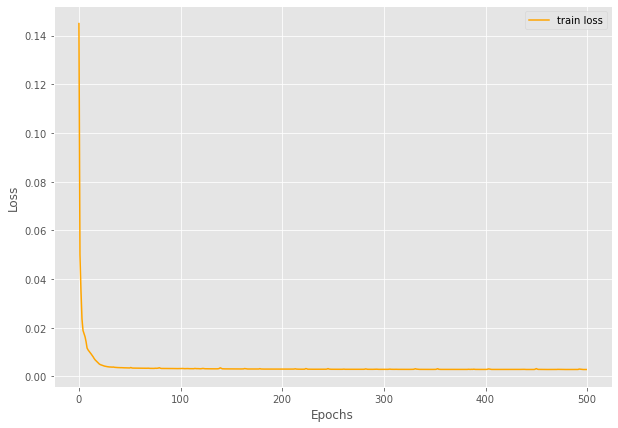

In [16]:
# loss plots
plt.figure(figsize=(10, 7))

plt.plot(train_loss, color='orange', label='train loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()
plt.show()

Plotting PSNR curve

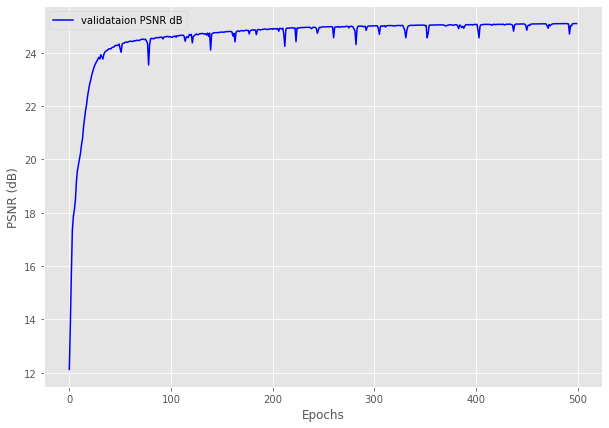

In [17]:
# psnr plots
plt.figure(figsize=(10, 7))

#plt.plot(train_psnr, color='green', label='train PSNR dB')
plt.plot(val_psnr, color='blue', label='validataion PSNR dB')

plt.xlabel('Epochs')
plt.ylabel('PSNR (dB)')

plt.legend()
#plt.savefig('../outputs/psnr.png')
plt.show()

### Evaluation

In [18]:
from __future__ import print_function
import argparse
import torch
from PIL import Image
from torchvision.transforms import ToTensor

import numpy as np

import cv2

In [19]:
#img = Image.open('dataset/BSDS300/images/test/101085.jpg')#.convert('YCbCr')
img = Image.open('lenna.png')
#y, cb, cr = img.split()

# load model
model = torch.load('model_epoch_500.pth')
img_to_tensor = ToTensor()
input = img_to_tensor(img).unsqueeze(0)#y).view(1, -1, y.size[1], y.size[0])

if device:
    model = model.cuda()
    input = input.cuda()

out = model(input)
out = out.cpu()

In [20]:
out = out.squeeze()
out.shape

torch.Size([3, 512, 512])

In [21]:
out_img = out.detach().numpy()
out_img = out_img.transpose(1, 2, 0)
out_img *= 255.0
out_img = out_img.clip(0, 255)
print(out_img.shape)

(512, 512, 3)


In [22]:
out_img = np.uint8(out_img)

Save image

In [23]:
out_img = Image.fromarray(out_img, "RGB")
out_img.save('lenna_out_500.png')
print('output image saved to ', 'lenna_out_500.png')

output image saved to  lenna_out_500.png


PSNR evaluation

In [24]:
img1 = cv2.imread('lenna.png')
img2 = cv2.imread('lenna_out_500.png')
psnr = cv2.PSNR(img1, img2)
psnr

30.245133572587